In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer

import nltk

import shap

# Load data

In [3]:
df = pd.read_csv('data/Sentences_clean.csv')

In [4]:
df.head()

,ID,Sentence_clean,sentiment
0,1,results nd line treatment show orr patient...,Positive
1,2,long duration response high durable response r...,Positive
2,4,therefore clinical benefit nd line treatment ...,Positive
3,5,data provided st line although preliminary sh...,Positive
4,6,taking account intrinsic limitation single arm...,Positive


In [5]:
# create stratified train test split 

train, test = train_test_split(df, test_size=0.2, train_size=0.8, stratify=df['sentiment'], random_state=0)

In [6]:
# encode target

le = LabelEncoder()

le.fit(train['sentiment'])

train['target'] = le.transform(train['sentiment'])
test['target'] = le.transform(test['sentiment'])

In [7]:
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

# Create features

In [8]:
# create bag of words

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['Sentence_clean'])
test_matrix = vectorizer.transform(test['Sentence_clean'])

# Train simple logistic regression model

In [9]:
X_train = train_matrix
X_test = test_matrix
y_train = train['target']
y_test = test['target']

In [10]:
# logistic regression model

lr = LogisticRegression(random_state=0)

# fit
lr.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [11]:
predictions = lr.predict(X_test)

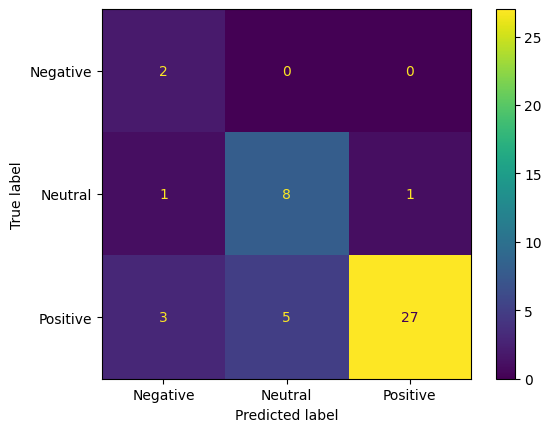

In [12]:
# plot confusions matrix

cf_matrix = confusion_matrix(predictions,y_test)

disp = ConfusionMatrixDisplay(cf_matrix, display_labels=le.classes_)

disp.plot()

plt.show()

In [13]:
print(classification_report(predictions,y_test, labels=[0,1,2], target_names=le.classes_))

              precision    recall  f1-score   support

    Negative       0.33      1.00      0.50         2
     Neutral       0.62      0.80      0.70        10
    Positive       0.96      0.77      0.86        35

    accuracy                           0.79        47
   macro avg       0.64      0.86      0.68        47
weighted avg       0.86      0.79      0.81        47



# Explain sentiment with SHAP

In [14]:
# initialize for plotting
shap.initjs()

In [15]:
# create linear SHAP explainer

explainer = shap.explainers.Linear(lr, X_train.toarray(),output_names=le.classes_, feature_names=vectorizer.get_feature_names_out())

# calculate SHAP values
shap_values = explainer.shap_values(X_test.toarray())

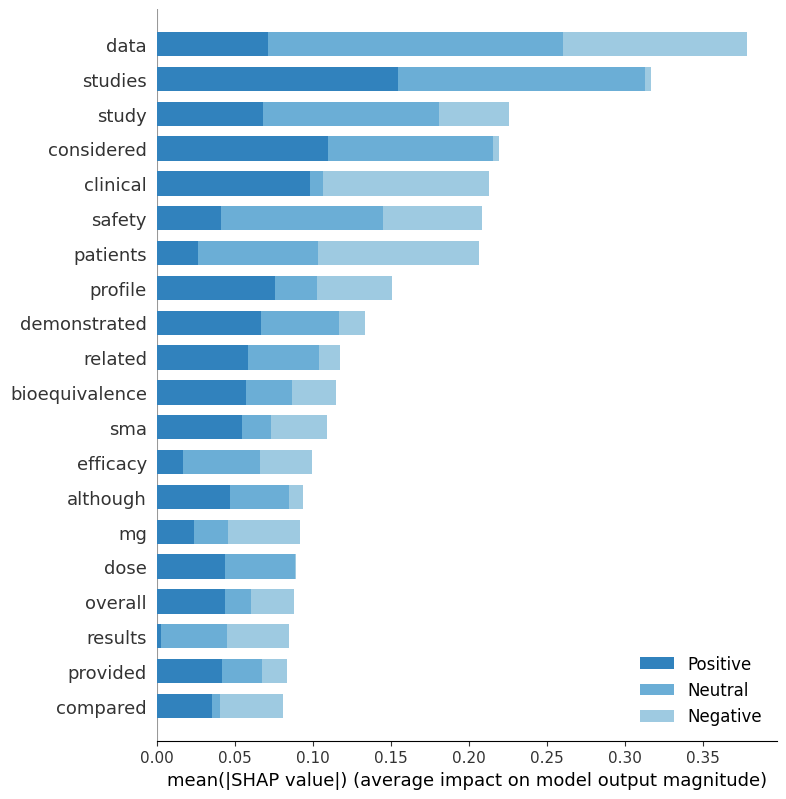

In [16]:
# create SHAP summary plot 
shap.summary_plot(shap_values, X_test.toarray(), plot_type="bar", class_names= le.classes_, feature_names = vectorizer.get_feature_names_out(), color=plt.get_cmap("tab20c"))

In [17]:
# create SHAP force plot for positive instance

idx = 1
# only explain prediction for top class
c = predictions[idx]

print('Force plot for test sample with index {} classified as {}'.format(idx, le.classes_[c].lower()))

shap.force_plot(explainer.expected_value[c], shap_values[c][idx,:], X_test.toarray()[idx], feature_names = vectorizer.get_feature_names_out())

Force plot for test sample with index 1 classified as positive


In [18]:
# create SHAP force plot for neutral instance
idx = 0
# only explain prediction for top class
c = predictions[idx]

print('Force plot for test sample with index {} classified as {}'.format(idx, le.classes_[c].lower()))

shap.force_plot(explainer.expected_value[c], shap_values[c][idx,:], X_test.toarray()[idx], feature_names = vectorizer.get_feature_names_out())

Force plot for test sample with index 0 classified as neutral


In [19]:
# create SHAP force plot for negative instance
idx = -5
# only explain prediction for top class
c = predictions[idx]

print('Force plot for test sample with index {} classified as {}'.format(idx, le.classes_[c].lower()))

shap.force_plot(explainer.expected_value[c], shap_values[c][idx,:], X_test.toarray()[idx], feature_names = vectorizer.get_feature_names_out())

Force plot for test sample with index -5 classified as negative
